In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch, torch.nn as nn
import Loader_ADNI_MUL3 as Loader
import Judge
import time
from Models.GRU import Model as RNN
from Models.MLP import Model as MLP
from Models.TOP import Model as TOP
from sklearn.metrics import classification_report, roc_curve, auc, roc_auc_score, confusion_matrix

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
LR = 3e-4
EPOCH = 800
n_fold = 15
TURN = 1
if_PRINT = True
if_valiSet = False
acc_list_total = []
best_roc_list, best_sen_list, best_spe_list = [], [], []
acc_TURN = []

<class 'list'>
<class 'list'>
in epoch 799, vali acc = 0.5 / 0.75(epoch:237) time: 59.282s


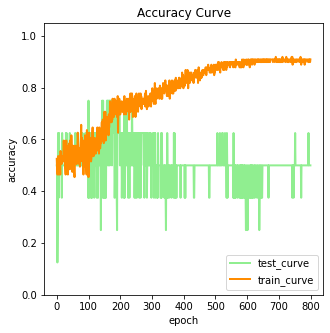

in epoch 799, vali acc = 0.5 / 0.88(epoch:140) time: 56.0309s


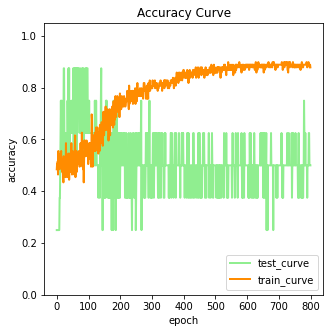

in epoch 799, vali acc = 0.57 / 0.86(epoch:83) time: 56.2138s


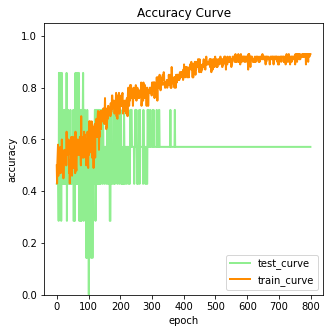

in epoch 799, vali acc = 0.71 / 1.0(epoch:274) time: 56.5365s


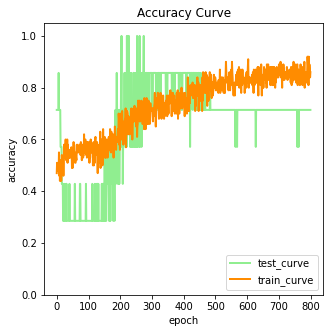

in epoch 799, vali acc = 0.71 / 0.86(epoch:779) time: 56.5641s


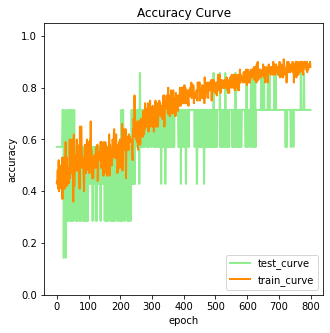

in epoch 799, vali acc = 0.29 / 0.86(epoch:129) time: 56.5868s


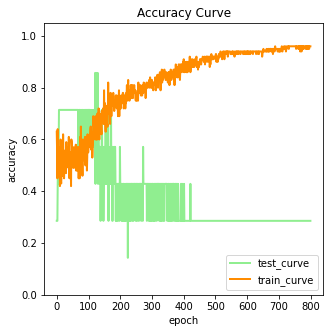

in epoch 799, vali acc = 0.86 / 1.0(epoch:779) time: 56.8258s


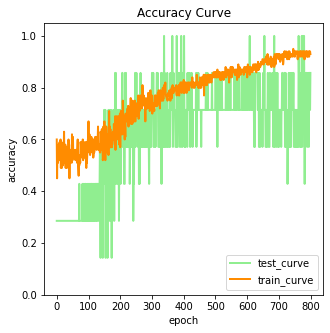

in epoch 799, vali acc = 0.86 / 0.86(epoch:798) time: 56.7593s


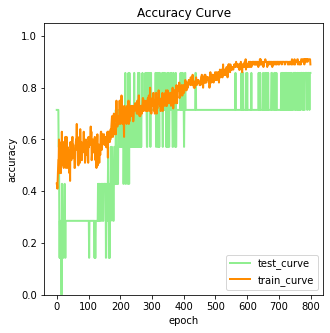

in epoch 799, vali acc = 0.57 / 1.0(epoch:105) time: 56.7266s


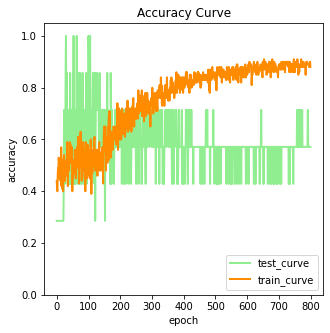

in epoch 799, vali acc = 0.57 / 0.86(epoch:496) time: 56.7006s


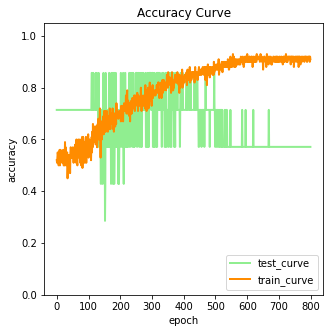

in epoch 799, vali acc = 0.57 / 0.86(epoch:255) time: 56.4751s


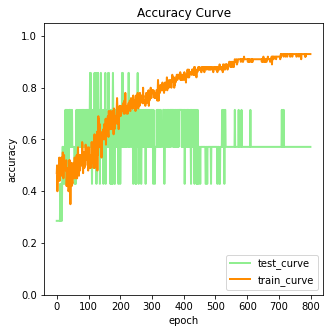

in epoch 799, vali acc = 0.71 / 0.86(epoch:225) time: 56.5903s


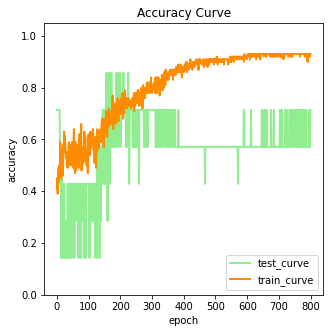

in epoch 799, vali acc = 0.43 / 0.86(epoch:112) time: 56.7011s


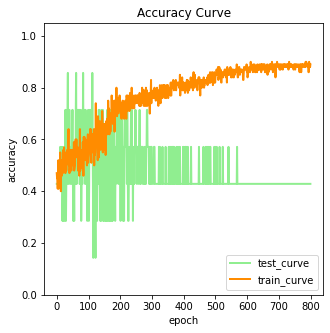

in epoch 799, vali acc = 0.43 / 0.81(epoch:209) time: 56.4961s


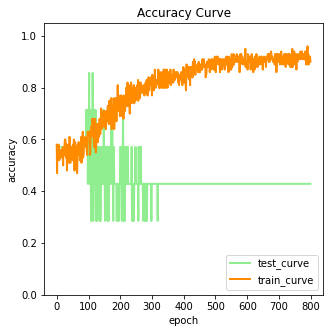

in epoch 799, vali acc = 0.57 / 0.86(epoch:249) time: 56.3422s


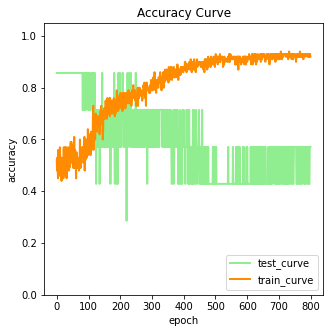

0.87658715
roc:0.8483333333333334, sensitivity:0.7400000000000001, specificity:0.9566666666666667


<Figure size 432x288 with 0 Axes>

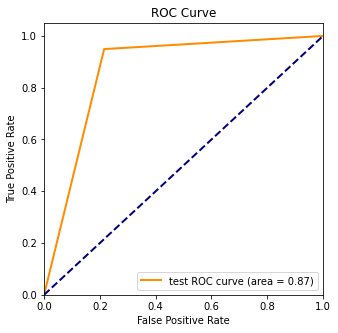

In [3]:
for turn in range(TURN):
    # I.准备数据
    DATA = Loader.Data(fold=n_fold, valiSet=if_valiSet, batch_size=25)
    Fold_Datasets, test_iter = DATA.Fold_Datasets, DATA.Test_Iter

    _labels_list, _preds_list = [], [] # 用来画最后的ROC曲线
    acc_list_test = []
    for each_Fold in Fold_Datasets:
        time_ST = time.perf_counter()

        # 0.模型实例化
        model1 = RNN(90, 45, 2).to(device)
        model2 = MLP().to(device)
        model3 = TOP().to(device)

        loss_fn = nn.CrossEntropyLoss().to(device)
        optim = torch.optim.Adam(list(model1.parameters()), lr=LR)
        optim_2 = torch.optim.ASGD(list(model2.parameters()), lr=LR/1000)
        optim_3 = torch.optim.Adam(list(model3.parameters()), lr=LR/100)
        acc_list_turn = []

        # 1.作图需要的参数
        _X = []
        _Y_train = []
        _Y_test = []

        # 2.最终评价指标
        good_acc = [0, 0, 0]  # TODO: 增加
        good_con_mat = [None, None, None]
        good_epoch = 0
        good_preds_list, good_labels_list = [None, None, None], [None, None, None]


        # 3.数据集
        train_iter, vali_iter = each_Fold

        # 4.开始训练
        for i in range(EPOCH):

            # 4.1 ------TRAIN PART-------
            model1.train()
            model2.train()
            model3.train()

            acc_for_train, count = 0, 0
            for train_batch in train_iter:
                [samples_seq, samples_cor], labels = train_batch
                samples_seq, samples_cor, labels = samples_seq.to(device), samples_cor.to(device), labels.to(device)

                outputs_seq = model1(samples_seq)
                outputs_cor = model2(samples_cor)
                outputs = model3(outputs_seq, outputs_cor)
                # recording acc
                preds = outputs.cpu().argmax(1)
                acc = (preds == labels.cpu()).sum()
                count += len(labels)
                acc_for_train += acc

                # loss computing, backward
                labels = labels.long()
                loss = loss_fn(outputs, labels)

                if i % 20 != 1:
                    optim.zero_grad()
                    loss.backward()
                    optim.step()
                else:
                    optim.zero_grad()
                    optim_2.zero_grad()
                    optim_3.zero_grad()
                    loss.backward()
                    optim.step()
                    optim_2.step()
                    optim_3.step()

            _Y_train.append(torch.true_divide(acc_for_train, count))
            _X.append(i)

            # 4.2 ------VALIDATION PART-------
            model1.eval()
            model2.eval()
            model3.eval()
            acc_for_vali, count = 0, 0
            con_mat_vali = np.zeros((2, 2))
            preds_list, labels_list = [], []
            for vali_batch in vali_iter:
                [samples_seq, samples_cor], labels = vali_batch

                samples_seq, samples_cor = samples_seq.to(device), samples_cor.to(device)
                outputs_seq = model1(samples_seq)
                outputs_cor = model2(samples_cor)
                outputs = model3(outputs_seq, outputs_cor)

                preds = outputs.cpu().argmax(1)
                preds_list += preds.tolist()
                labels_list += labels.tolist()
                acc = (preds == labels).sum()
                count += len(labels)
                acc_for_vali += acc

                for one in range(preds.shape[0]):
                    con_mat_vali[int(labels[one].item()), preds[one]] += 1

            _Y_test.append(torch.true_divide(acc_for_vali, count))

            # 4.2.1 打印总结
            print('\rin epoch {}, vali acc = {} / {}(epoch:{})'.format(i, round(float(torch.true_divide(acc_for_vali, count)), 2),
                                                                       round(float(np.mean(np.asarray(good_acc))), 2), good_epoch), end='')

            acc_list_turn.append(torch.true_divide(acc_for_vali, count))

            # 4.2.2 记录最好的值
            b_acc = min(good_acc)   # TODO: 修改
            ind_b_acc = good_acc.index(b_acc)
            if torch.true_divide(acc_for_vali, count) >= b_acc:
                good_acc[ind_b_acc] = torch.true_divide(acc_for_vali, count)
                good_con_mat[ind_b_acc] = con_mat_vali
                good_epoch = i
                good_labels_list[ind_b_acc] = labels_list
                good_preds_list[ind_b_acc] = preds_list

        time_ED = time.perf_counter()
        print(' time: {}s'.format(round((time_ED - time_ST), 4)))

        # 6.记录所有的评价参数
        good_roc = 0
        good_sensitivity = 0
        good_specificity = 0
        for i in range(len(good_acc)):  # TODO: 修改
            _preds_list += good_preds_list[i]
            _labels_list += good_labels_list[i]
            try:
                good_roc += Judge.mat_roc(good_con_mat[i].astype(dtype=int))
                good_sensitivity += Judge.mat_sensitivity(good_con_mat[i].astype(dtype=int))
                good_specificity += Judge.mat_specify(good_con_mat[i].astype(dtype=int))
            except:
                print('')
        best_roc_list.append(good_roc / len(good_acc))
        best_sen_list.append(good_sensitivity / len(good_acc))
        best_spe_list.append(good_specificity / len(good_acc))

        acc_list_test.append(np.mean(np.asarray(good_acc)))

        if if_PRINT:
            # plt
            plt.figure(figsize=(5, 5))
            plt.plot(_X, _Y_test, c='lightgreen', lw=2, label='test_curve')
            plt.plot(_X, _Y_train, c='darkorange', lw=2, label='train_curve')
            plt.xlabel('epoch')
            plt.ylabel('accuracy')
            plt.ylim([0, 1.05])
            plt.title('Accuracy Curve')
            plt.legend(loc="lower right")
            plt.show()

    # Fold结束，对所有fold的平均
    print(np.mean(np.asarray(acc_list_test)))
    print('roc:{}, sensitivity:{}, specificity:{}'.format(np.mean(np.asarray(best_roc_list)),
                                                          np.mean(np.asarray(best_sen_list)),
                                                          np.mean(np.asarray(best_spe_list))))
    acc_TURN.append(np.asarray(acc_list_test))

    Judge.auc_sens_spe_cal(_labels_list, _preds_list, draw="true")